# AI-PBPK model project: hyperparameters tuning with BayesSearchCV 
Author: Wei-Chun Chou  
Date created: 2022/06/09  
Description: In this study, we used lightGBM and Deep nerual network model to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/AI-Toxicology"

# choose where you want your project files to be saved
project_folder = "/Project_2_AI-PBPK/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

ID               0
Type             0
TS               0
HD              36
Zeta            44
Charge          40
Shape            0
TM               0
CT               0
TSz             31
TW               0
Dose             0
BW               0
DE24             0
DE168            0
Demax            0
KTRESrelease     0
KTRESmax         0
KTRES50          0
KTRESn           0
dtype: int64

In [ ]:
# Remove the row with missing data
Data=Data.dropna() # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)
df_X = df[["Type","TS","HD","Zeta","Charge","Shape", "TM", "CT", "TSz", "TW"]]
df_y = df[["KTRESrelease","KTRESn","KTRESmax", "KTRES50"]]

In [ ]:
## Replace mising value with "Mean" or "Frequency values"
imputer_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer_freq = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
cols_num = ['HD','Zeta',"TSz",'TW']
cols_label = ['Type','TS','Charge','Shape','TM','CT']

imputer_mean = imputer_mean.fit(df_X[cols_num])
imputer_freq = imputer_freq.fit(df_X[cols_label])
df_X[cols_num] = imputer_mean.transform(df_X[cols_num])
df_X[cols_label] = imputer_freq.transform(df_X[cols_label])


# 3. Taking care of Categorical Features


In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels of multiple columns at once
test_X[cols_label] = test_X[cols_label].apply(LabelEncoder().fit_transform)

print(test_X)

     Type  TS     HD  Zeta  Charge  Shape  TM  CT    TSz     TW
4       1   0   68.4   9.3       0      2   3  13  0.175  0.210
5       1   1  166.0   6.0       0      6   4  16  1.100  1.320
6       1   0  175.6   5.0       0      6   4  16  1.100  1.320
7       1   1  104.2  10.0       0      6   4  16  1.100  1.320
8       1   1   64.2  15.0       0      6   4  16  1.100  1.320
..    ...  ..    ...   ...     ...    ...  ..  ..    ...    ...
373     2   1   92.0   0.0       2      6   3   1  0.530  0.636
374     2   1   92.0   0.0       2      6   3   1  0.530  0.636
375     2   1   92.0   0.0       2      6   3   1  0.530  0.636
376     2   1  122.5  13.2       0      6   3   6  0.300  0.360
377     2   1  190.5  10.1       0      4   1  11  0.100  0.120

[288 rows x 10 columns]


# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['HD','Zeta',"TSz","TW"]

scaler = StandardScaler()
mscaler = MinMaxScaler()

Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

           HD      Zeta       TSz        TW
0    0.139468  0.033917  0.087079  0.087079
1    0.355876  0.021882  0.606742  0.606742
2    0.377162  0.018235  0.606742  0.606742
3    0.218847  0.036470  0.606742  0.606742
4    0.130155  0.054705  0.606742  0.606742
..        ...       ...       ...       ...
283  0.191796  0.000000  0.286517  0.286517
284  0.191796  0.000000  0.286517  0.286517
285  0.191796  0.000000  0.286517  0.286517
286  0.259424  0.048140  0.157303  0.157303
287  0.410200  0.036834  0.044944  0.044944

[288 rows x 4 columns]


# Onehot encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
cols_label_1hot = ['TS','TM',"CT",'Shape']
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names(cols_label_1hot)

print(data_cat_1hot)

     TS_0  TS_1  TS_2  TS_3  TM_0  TM_1  TM_2  TM_3  TM_4  CT_0  ...  CT_15  \
0     1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
1     0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
2     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
3     0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
4     0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
283   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
284   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
285   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
286   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
287   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...    0.0   

     CT_16  CT_17  Shape_0  Shape_1  Shape_2  Shape

In [ ]:
cols_label_bi = ['Type',"TS",'Charge']
data_cat_bi = test_X[cols_label_bi]
preData=pd.concat([Data_num_tr, data_cat_1hot], axis=1)
print(preData)

           HD      Zeta       TSz        TW  TS_0  TS_1  TS_2  TS_3  TM_0  \
0    0.139468  0.033917  0.087079  0.087079   1.0   0.0   0.0   0.0   0.0   
1    0.355876  0.021882  0.606742  0.606742   0.0   1.0   0.0   0.0   0.0   
2    0.377162  0.018235  0.606742  0.606742   1.0   0.0   0.0   0.0   0.0   
3    0.218847  0.036470  0.606742  0.606742   0.0   1.0   0.0   0.0   0.0   
4    0.130155  0.054705  0.606742  0.606742   0.0   1.0   0.0   0.0   0.0   
..        ...       ...       ...       ...   ...   ...   ...   ...   ...   
283  0.191796  0.000000  0.286517  0.286517   0.0   1.0   0.0   0.0   0.0   
284  0.191796  0.000000  0.286517  0.286517   0.0   1.0   0.0   0.0   0.0   
285  0.191796  0.000000  0.286517  0.286517   0.0   1.0   0.0   0.0   0.0   
286  0.259424  0.048140  0.157303  0.157303   0.0   1.0   0.0   0.0   0.0   
287  0.410200  0.036834  0.044944  0.044944   0.0   1.0   0.0   0.0   0.0   

     TM_1  ...  CT_15  CT_16  CT_17  Shape_0  Shape_1  Shape_2  Shape_3  \


# Feature selection

In [ ]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
#X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = pd.DataFrame(fs.fit_transform(preData, df_y['KTRESmax']))
cols = fs.get_feature_names_out()
X_selected.columns = cols
print(X_selected)

           HD      Zeta  TM_0  TM_3  CT_1  CT_3  CT_5  CT_13  Shape_2  Shape_4
0    0.139468  0.033917   0.0   1.0   0.0   0.0   0.0    1.0      1.0      0.0
1    0.355876  0.021882   0.0   0.0   0.0   0.0   0.0    0.0      0.0      0.0
2    0.377162  0.018235   0.0   0.0   0.0   0.0   0.0    0.0      0.0      0.0
3    0.218847  0.036470   0.0   0.0   0.0   0.0   0.0    0.0      0.0      0.0
4    0.130155  0.054705   0.0   0.0   0.0   0.0   0.0    0.0      0.0      0.0
..        ...       ...   ...   ...   ...   ...   ...    ...      ...      ...
283  0.191796  0.000000   0.0   1.0   1.0   0.0   0.0    0.0      0.0      0.0
284  0.191796  0.000000   0.0   1.0   1.0   0.0   0.0    0.0      0.0      0.0
285  0.191796  0.000000   0.0   1.0   1.0   0.0   0.0    0.0      0.0      0.0
286  0.259424  0.048140   0.0   1.0   0.0   0.0   0.0    0.0      0.0      0.0
287  0.410200  0.036834   0.0   0.0   0.0   0.0   0.0    0.0      0.0      1.0

[288 rows x 10 columns]


In [ ]:
y_re = df_y['KTRESrelease']
X_re = preData

# LightGbm model with pretest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Ridge

In [ ]:
models_to_run = [Ridge(), SVR(), RandomForestRegressor(), xgb.XGBRegressor(), lgb.LGBMRegressor()]

model_parm_search = [
    { # linear
     #'alpha': Real(1e-5, 100, prior='log-uniform'),
     "solver":Categorical(['svd', 'cholesky', 'lsqr', 'sag']),
     'fit_intercept':Categorical(["True", "False"]),
    },
    
    { # SVR
     #'C': Real(1e-6, 1e+6, prior='log-uniform'),
     "kernel":Categorical(['linear','poly','rbf','sigmoid']),
     #'gamma':Real(1e-6, 1e+1, prior='log-uniform'),
     "epsilon":Integer(0,1),
    },

    { # 1st parm corresponding to RandomForestRegressor
     'max_depth': Integer(3, 12),
     'n_estimators': Integer(100, 1000),
     'max_features': Integer(10, 34),
    },

    { # 2nd param grid, corresponding to XGBRegressor
     #'learning_rate': Real(1e-4, 1.0, 'log-uniform'),
     'colsample_bytree': Real(0.1, 0.9),
     'n_estimators': Integer(100, 1000),
     'reg_alpha': Real(1, 1.5,'log-uniform'),
     'reg_alpha': Real(1, 1.5,'log-uniform'),
    },

    { # 3rd param grid, corresponding to LGBMRegressor
     #'learning_rate': Real(1e-3, 1.0, 'log-uniform'),
     'n_estimators': Integer(100, 1000),
     'max_depth': Integer(3, 12),
     'reg_alpha': Real(1, 1.5,'log-uniform'),
     'reg_alpha': Real(1, 1.5,'log-uniform'),
    }
]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=2)


In [ ]:
from sklearn.metrics import mean_squared_error as mse

cv = KFold(n_splits=5, shuffle=True, random_state=7)

for i, model in enumerate(models_to_run):
   # build the Bayesian search model
   bs = BayesSearchCV(
       estimator=model,
       search_spaces=model_parm_search[i],
       cv = cv,
       n_iter = 80,
       n_jobs = -1, 
       scoring = "neg_root_mean_squared_error",
       return_train_score=True,
       random_state = 1
   )

   bs.fit(X_train, y_train)
   
   model    = bs.best_estimator_
   test_preds  = model.predict(X_test)
   train_preds = model.predict(X_train)
   all_preds  = model.predict(X_re)
   y_obs    = y_re.tolist()
    
   r2_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='r2')
   rmse_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

   print('\nThe 5-CV rmse Score was:', rmse_kfolds.mean()) 
   print('With a standard deviation of:', rmse_kfolds.std())
   print('Test rmse socre: %.2f' %mse(y_test, test_preds, squared=False))

   print('\nThe 5-CV R2 Score was:', r2_kfolds.mean()) 
   print('With a standard deviation of:', r2_kfolds.std())
   print("Test R2 Score : %.2f" %r2_score(y_test, test_preds))
   print("Train R2 Score : %.2f" %r2_score(y_train, train_preds))
   print("All R2 Score : %.2f" %r2_score(y_obs, all_preds)) 

KeyboardInterrupt: ignored

# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam


In [ ]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)


(288, 38) (288,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=2)

# Tuning Model with Keras Tuner

In [ ]:
def build_model(hp):
  model = Sequential()
  
  # Input layer
  model.add(Dense(units = hp.Int('dense-bot', min_value=38, 
             max_value=512, step=50, default=38),
             activation = hp.Choice(
                 'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
             input_shape=(X.shape[1],)))
  

  # Tune the number of units in the each dense layer 
  for i in range (hp.Int('num_dense_layers',1,3)):
    model.add(Dense(units=hp.Int('dense_'+str(i), min_value=50, max_value=512, step=25),
          activation = hp.Choice('act_l1',['relu','tanh','sigmoid'])))
    
    # Tune the droput rate in the each dense layer
    model.add(Dropout(hp.Float('dropout_'+ str(i), min_value=0.0, max_value=0.5, step=0.1)))

  
  # add output    
  model.add(layers.Dense(1,activation='linear'))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  
  if hp_optimizer == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
  
  elif hp_optimizer == 'SGD':
     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
     nesterov=True
     momentum=0.9
  
  model.compile(
    optimizer=hp_optimizer,
    loss='mse',
    metrics=['mse'])
  
  return model

In [ ]:
# Check if the model code work correctly
import keras_tuner
build_model(keras_tuner.HyperParameters())


In [ ]:
# seed the random number generator to reproduce the same results
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(2)

In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel = build_model,
            objective = 'val_mse',
            max_trials = 10, #90
            overwrite = True,
            executions_per_trial=1)

In [ ]:
tuner_bo.search(X_train, y_train, 
        validation_data=(X_test, y_test),
        batch_size = 64,
        epochs = 900, verbose = 0)

In [ ]:
# Get the top 2 models
best_params=tuner_bo.get_best_hyperparameters()
best_params[0].values

{'dense-bot': 38,
 'dense_activation': 'relu',
 'num_dense_layers': 3,
 'dense_0': 500,
 'act_l1': 'relu',
 'dropout_0': 0.1,
 'Optimizer': 'SGD',
 'learning_rate': 1e-05,
 'dense_1': 500,
 'dropout_1': 0.5,
 'dense_2': 50,
 'dropout_2': 0.5}

In [ ]:
best_model=tuner_bo.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 38)                1482      
                                                                 
 dense_1 (Dense)             (None, 500)               19500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 50)                25050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

In [ ]:
from sklearn.metrics import r2_score
best_model = tuner_bo.get_best_models()[0] 

test_preds = best_model.predict(X_test)
train_preds = best_model.predict(X_train)
all_preds  = best_model.predict(X_re)
y_obs    = y_re.tolist()

print("\nTest R2 Score : %.2f" %r2_score(y_test, test_preds))
print("Train R2 Score : %.2f" %r2_score(y_train, train_preds))
print("All R2 Score : %.2f" %r2_score(y_obs, all_preds))
print('Test rmse socre: %.2f' %mse(y_test, test_preds, squared=False))


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 10ms/step


9/9 [==============================] - 0s 2ms/step

Test R2 Score : 0.45
Train R2 Score : 0.64
All R2 Score : 0.59
Test rmse socre: 1.89


In [ ]:
# save model and architecture to single file
#best_model.save("KTRESrel_best_model.h5")
#print("Saved model to disk")

Saved model to disk


In [ ]:
best_model_v2 = load_model('KTRESrel_best_model.h5')
test_preds_v2 = best_model_v2.predict(X_test)
train_preds_v2 = best_model_v2.predict(X_train)
all_preds_v2  = best_model_v2.predict(X_re)
y_obs    = y_re.tolist()

print("\nTest R2 Score : %.2f" %r2_score(y_test, test_preds_v2))
print("Train R2 Score : %.2f" %r2_score(y_train, train_preds_v2))
print("All R2 Score : %.2f" %r2_score(y_obs, all_preds_v2))
print('Test rmse socre: %.2f' %mse(y_test, test_preds, squared=False))

9/9 [==============================] - 0s 13ms/step

Test R2 Score : 0.47
Train R2 Score : 0.97
All R2 Score : 0.84
Test rmse socre: 2.28


# Display the R-squared value on scatterplot with regression model 

TypeError: ignored

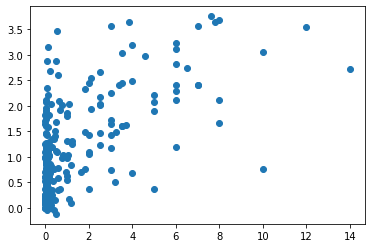

In [ ]:
import matplotlib.pyplot as plt

# create basic catterplot
plt.plot(y_obs, all_preds,'o')

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_obs, all_preds, 1)

# add linear regression line to scatterplot
plt.plot(y_obs, m*y_obs+b)

# K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse


dnn_best_model = best_model_v2 

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
cvr2scores = []
cvrmsescores = []

for train_ix, test_ix in kfold.split(X_train):
  # split data
  X_trian_n, X_test_n = X_train[train_ix], X_train[test_ix]
  y_trian_n, y_test_n = y_train[train_ix], y_train[test_ix]
  # create model
  
  dnn_best_model.fit(X_trian_n,y_trian_n, epochs=600, batch_size=64, verbose=0)
  test_pred = dnn_best_model.predict(X_test_n)
  r2score = r2_score(y_test_n, test_pred)
  rmse   = mse(y_test_n, test_pred,squared=False)

  #print("Test R2 Score : %.2f" %r2score)
  #print("Test RMSE Score : %.2f" %rmse)
  
  cvr2scores.append(r2score)
  cvrmsescores.append(rmse)

print("The 5-cv r2 Score was: %.2f (+/-) %.2f" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-cv rmse Score was: %.2f (+/-) %.2f" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


2/2 [==============================] - 0s 11ms/step


# Save predicted values (to csv file)

In [ ]:
PredKmax = pd.concat([pd.DataFrame(Data.dropna()["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","KTRESrelease", "Pred_KTRESrelease"]
PredKmax.to_csv('output_KTRESrelease.csv', encoding = 'utf-8-sig',index=False)